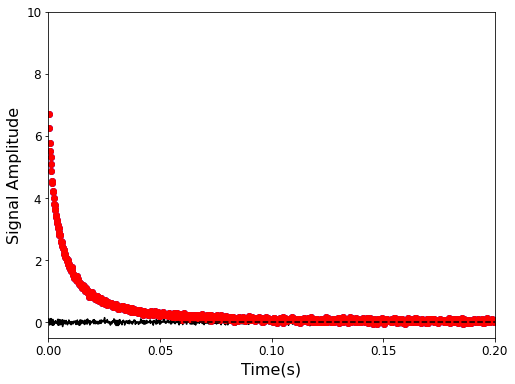

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cmath
%matplotlib inline

df = pd.read_csv('D:/MolineSamples/B4_1_A/CPMG200/1/data.csv', sep = ',',header = None)
temp_df = np.array(df)
time = temp_df[:,0]/1000
data = temp_df[:,1]
noise = temp_df[:,2]

fig=plt.figure(figsize=(8,6))
plt.plot(time,data,'bo',time,noise,'k')
# plt.plot(time,data,marker='o',color='b',markersize=1,linewidth=0)
x = data
y = noise
z = data + 1j*noise

temp_zphase = np.angle(z)
ztheta = np.mean(temp_zphase[0:20])
z = z*np.exp(-1j*ztheta)
noise = z.imag
data = z.real
plt.plot(time,data,'ro')
plt.plot([0,2],[0,0],'k--')
plt.xlim(0,0.2)
plt.ylim(-0.5,10)
plt.xlabel('Time(s)',fontsize=16)
plt.ylabel('Signal Amplitude',fontsize=16)
plt.xticks([0,0.05,0.1,0.15,0.2],fontsize=12)
plt.yticks(fontsize=12)
plt.show()
fig.savefig('NMRSignal.png',bbox_inches='tight')